## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy.stats as stats
import statsmodels.api as sm
import ptitprince as pt

from pandas.plotting import scatter_matrix
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score
from sklearn.datasets import make_classification
from sklearn.metrics import precision_recall_curve, roc_curve, confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, auc
from sklearn.preprocessing import Normalizer
from sklearn import metrics

import sys
sys.path.insert(0, '../src')
sys.path.insert(0, '../data')

import functions
import plot
import clean
import models

from sklearn.preprocessing import Normalizer

%load_ext autoreload
%autoreload 2


## Setup variables

In [2]:
poas_rank_vals = {'PV2': 2, 'PFC': 3, 'CPL': 4, 'SPC': 4, 'SGT': 5, 'SSG': 6}
sfas_rank_vals = {'PV2': 2, 'PFC': 3, 'CPL': 4, 'SPC': 4, 'SGT': 5, 'SSG': 6, 'SFC': 7, 'SSGT': 6, 'SRA': 4, 'SN': 3, 'AF': 4}
columns = ['DEP', 'PT', 'AGE', 'GT', 'EL', 'SC', 'CO', 'FA', 'ST']
new_labels = {'SEC': 'SECURITY CLEARANCE', 'AB': 'AIRBORNE', 'RGR': 'RANGER', 'DEP': 'DEPENDENTS', 'LANG': 'LANGUAGE', 'GT': 'GENERTAL TECHNICAL', 'EL': 'ELECTRONICS', 'SC': 'SURVEILLANCE AND COMMUNICATIONS', 'CO': 'COMBAT', 'FA': 'FIELD ARTILLERY', 'ST': 'SKILLED TECHNICAL', 'CODE': 'SELECT'}

poas_filepath = '../data/poas'
poas_filenames = ['poas16.xlsx', 'poas17.xlsx', 'poas18.xlsx', 'poas19.xlsx', 'poas20.xlsx', 'poas21.xlsx', 'poas22.xlsx']

sfas_filepath = '../data/sfas'
sfas_filenames = ['sfas16.xlsx', 'sfas17.xlsx', 'sfas18.xlsx', 'sfas19.xlsx', 'sfas20.xlsx', 'sfas21.xlsx', 'sfas22.xlsx']

## Data Import & Cleaning

In [3]:
poas = clean.clean_data(poas_filepath, poas_filenames, columns, 'POAS')
sfas = clean.clean_data(sfas_filepath, sfas_filenames, columns, 'SFAS')

/opt/anaconda3/lib/python3.9/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Data Validation extension is not supported and will be removed
  for idx, row in parser.parse():
/opt/anaconda3/lib/python3.9/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Conditional Formatting extension is not supported and will be removed
  for idx, row in parser.parse():


## Initial Overview

View of overall data

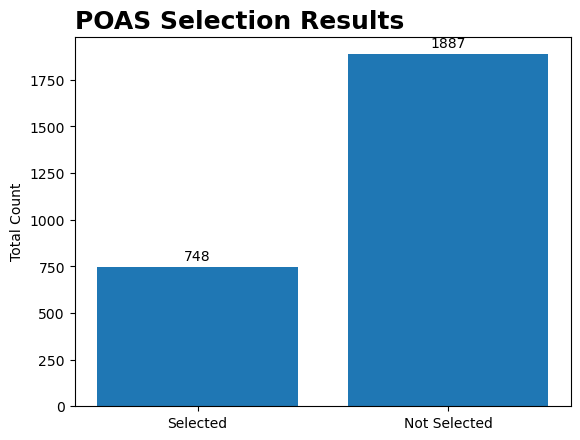

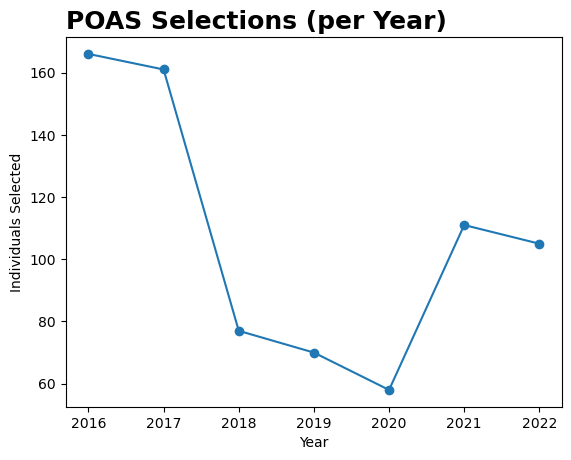

In [4]:
poas_outcome = functions.outcomes(poas, 'RESULT', 'SELECTED')

plot.select_bar_plot(poas_outcome[0], ['Selected', 'Not Selected'] , 'POAS Selection Results', 'Total Count')
plot.annual_line_plot(poas_outcome[1], 'POAS Selections (per Year)', 'Year', 'Individuals Selected')

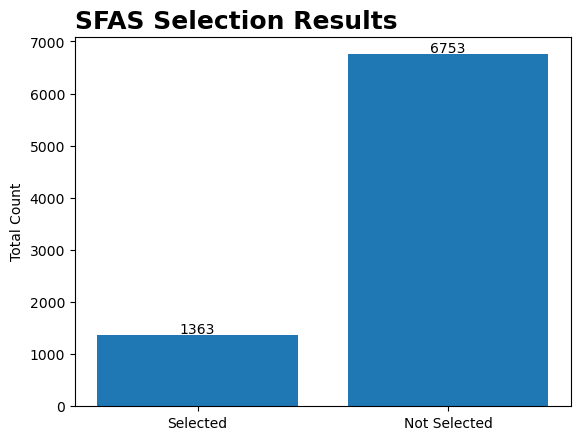

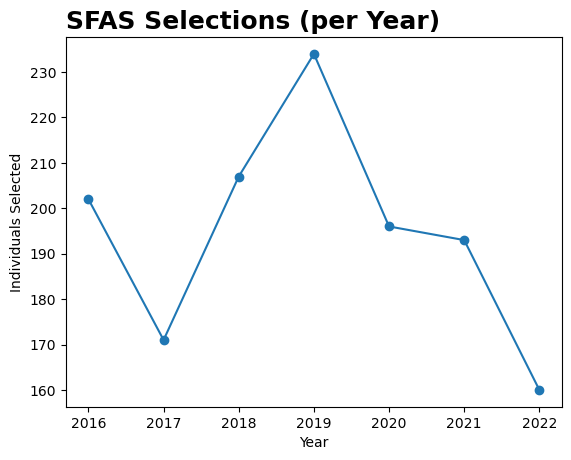

In [5]:
sfas_outcome = functions.outcomes(sfas, 'RESULT', 'SELECTED')

plot.select_bar_plot(sfas_outcome[0], ['Selected', 'Not Selected'] , 'SFAS Selection Results', 'Total Count')
plot.annual_line_plot(sfas_outcome[1], 'SFAS Selections (per Year)', 'Year', 'Individuals Selected')

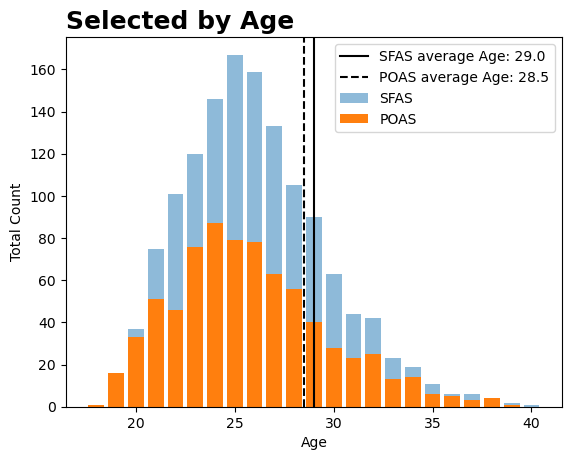

In [6]:
poas_ages, sfas_ages = functions.age_counts(poas_outcome[1], sfas_outcome[1], 'AGE')

plot.age_bar(poas_ages, sfas_ages, 'AGE', 'counts', 'Selected by Age', 'Age', 'Total Count')

## Key Features

Numerical look at features that are often considered "important"

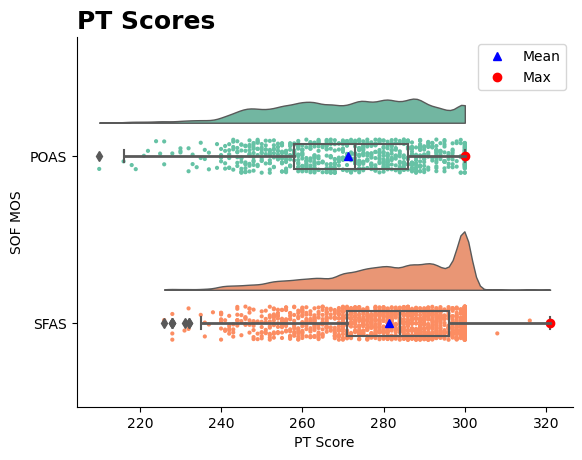

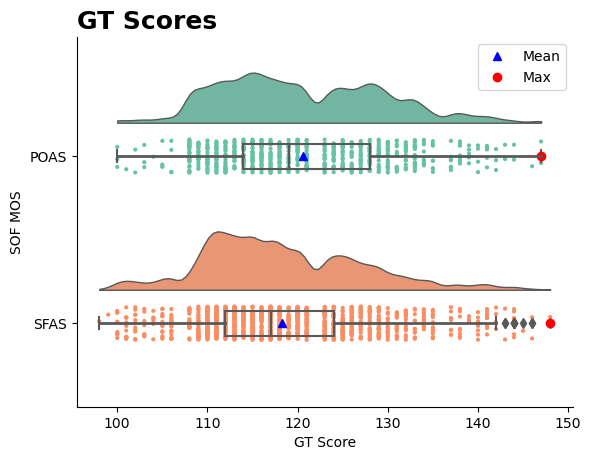

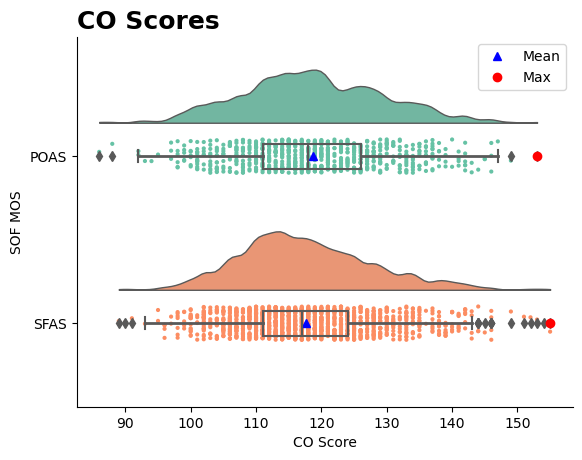

In [7]:
combined, combined_selected = functions.combined_features(poas, sfas, 'RESULT', 'SELECTED')
pt_df = combined_selected.loc[(combined_selected.PT > 200) & (combined_selected.PT < 350)]

plot.raincloud_plot('GROUP', 'PT', pt_df, 'PT Scores', 'PT Score', 'SOF MOS')
plot.raincloud_plot('GROUP', 'GT', combined_selected, 'GT Scores', 'GT Score', 'SOF MOS')
plot.raincloud_plot('GROUP', 'CO', combined_selected, 'CO Scores', 'CO Score', 'SOF MOS')

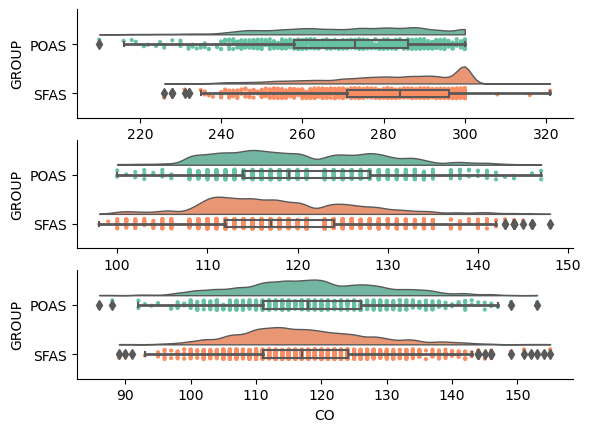

In [8]:
plot.raincloud_triple('GROUP', 'PT', 'GT', 'CO', combined_selected, pt_df)

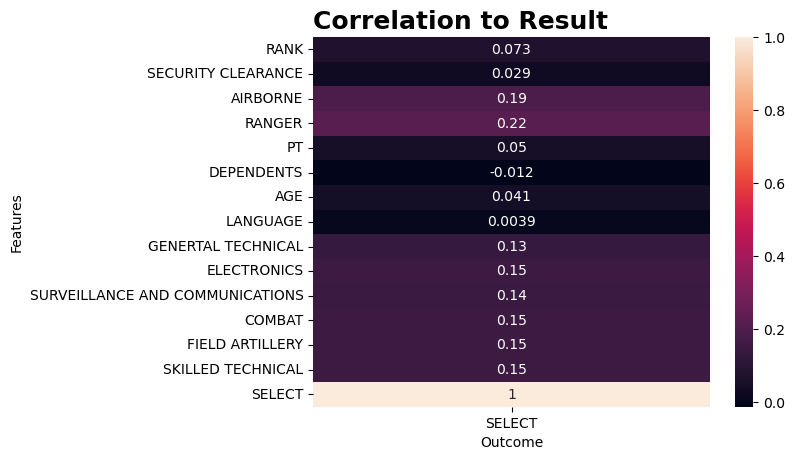

In [9]:
combined = combined.drop('YEAR', axis=1)
functions.new_labels(combined, new_labels)
functions.replace_vals(combined, 'RANK', sfas_rank_vals)
functions.replace_vals(combined, 'RANK', poas_rank_vals)
plot.select_correlation(combined, 'Correlation to Result', 'Outcome', 'Features')

## POAS Pre-Model

In [10]:
functions.replace_vals(poas, 'RANK', poas_rank_vals)
poas2 = poas.drop(['YEAR', 'RACE', 'MOS', 'ED', 'MARITAL', 'RESULT', 'GROUP'], axis=1)
poasX, poasX2, poasy = functions.return_x_y(poas2, 'CODE')
poas_split = functions.train_split(poasX2, poasy)

## POAS Info

In [11]:
poas_info = sm.Logit(poas_split[2], poas_split[0]).fit()
print(poas_info.summary())

Optimization terminated successfully.
         Current function value: 0.568286
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                   CODE   No. Observations:                 2108
Model:                          Logit   Df Residuals:                     2093
Method:                           MLE   Df Model:                           14
Date:                Thu, 09 Feb 2023   Pseudo R-squ.:                 0.04713
Time:                        16:39:54   Log-Likelihood:                -1197.9
converged:                       True   LL-Null:                       -1257.2
Covariance Type:            nonrobust   LLR p-value:                 1.229e-18
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1           -24.4451     27.644     -0.884      0.377     -78.626      29.736
x2            17.8429     60.

## POAS Logistic Regression Model

Single Logistic Regression Model

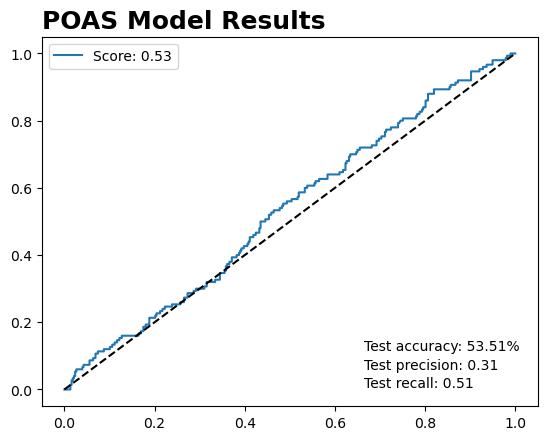

In [12]:
poas_single_model = models.regression_model(poas_split[0], poas_split[1], poas_split[2], poas_split[3], 'POAS Model Results', 'Simple Logistic Regression')

KFold Model

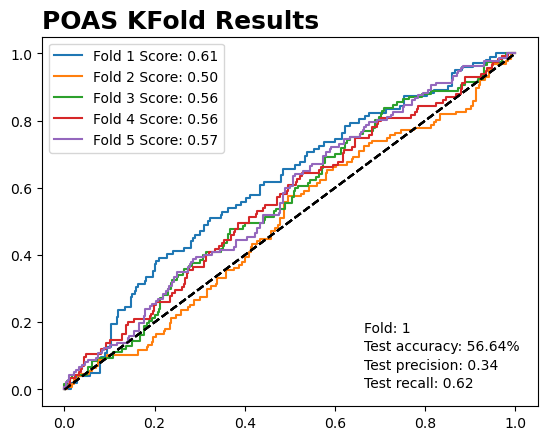

In [13]:
poas_multi = models.multiple_regression_model(poasX, poasy, 5, 'POAS KFold Results')

## SFAS Pre-Model


In [14]:
functions.replace_vals(sfas, 'RANK', sfas_rank_vals)
sfas2 = sfas.drop(['YEAR', 'RACE', 'MOS', 'ED', 'MARITAL', 'RESULT', 'GROUP'], axis=1)
sfasX, sfasX2, sfasy = functions.return_x_y(sfas2, 'CODE')
sfas_split = functions.train_split(sfasX2, sfasy)

## SFAS Info

In [15]:
sfas_info = sm.Logit(sfas_split[2], sfas_split[0]).fit()
print(sfas_info.summary())

Optimization terminated successfully.
         Current function value: 0.409244
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                   CODE   No. Observations:                 6492
Model:                          Logit   Df Residuals:                     6477
Method:                           MLE   Df Model:                           14
Date:                Thu, 09 Feb 2023   Pseudo R-squ.:                 0.09567
Time:                        16:39:55   Log-Likelihood:                -2656.8
converged:                       True   LL-Null:                       -2937.9
Covariance Type:            nonrobust   LLR p-value:                6.003e-111
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            67.2824     19.110      3.521      0.000      29.827     104.737
x2          -101.4653     47.

## SFAS Logistic Regression Model

Single Logistic Regression Model

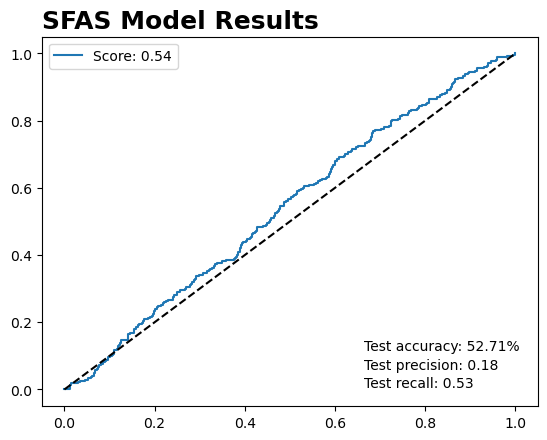

In [16]:
sfas_single_model = models.regression_model(sfas_split[0], sfas_split[1], sfas_split[2], sfas_split[3], 'SFAS Model Results')

KFold Model

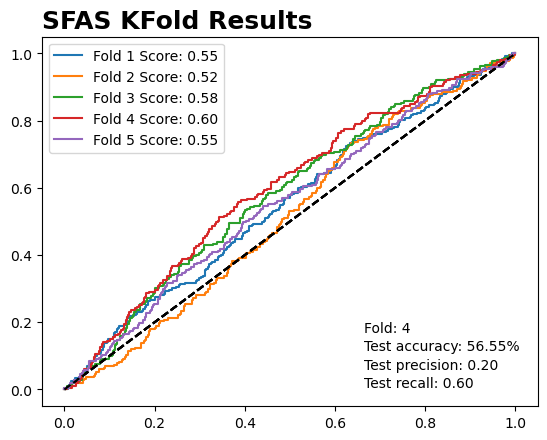

In [17]:
sfas_multi = models.multiple_regression_model(sfasX, sfasy, 5, 'SFAS KFold Results')

## Significant Feature Models

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

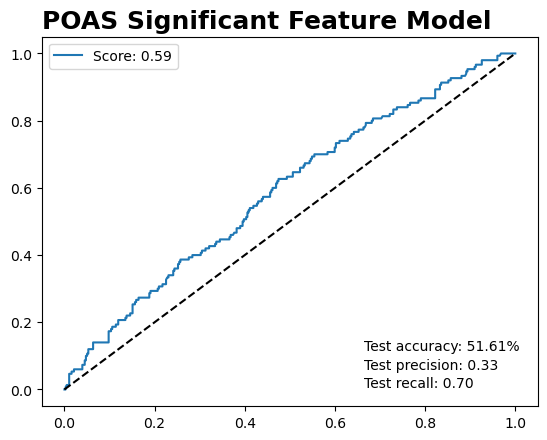

In [18]:
refined_poas_split = functions.sig_feature_split(poas2, 'CODE')
refined_poas_model = models.regression_model(refined_poas_split[0], refined_poas_split[1], refined_poas_split[2], refined_poas_split[3], 'POAS Significant Feature Model')

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

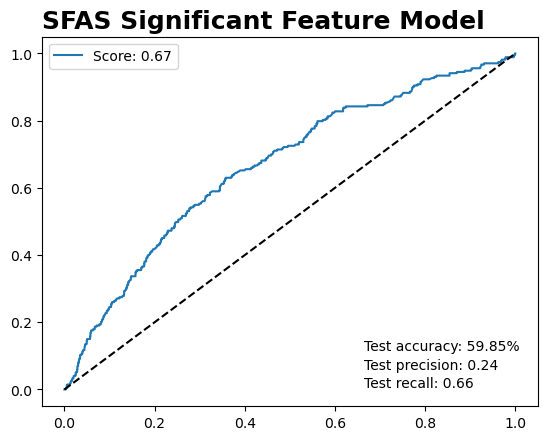

In [19]:
refined_sfas_split = functions.sig_feature_split(sfas2, 'CODE')
refined_sfas_model = models.regression_model(refined_sfas_split[0], refined_sfas_split[1], refined_sfas_split[2], refined_sfas_split[3], 'SFAS Significant Feature Model')